# Anomaly detection with autoencoders

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix



In autoencoder 

- When we train on normal data and then test on anomalous data
- we expect the model to reconstruct normal patterns but fail to accurately reconstruct anomalies
- we need to examine the reconstruction error rather than just the reconstructed series
- When tested on anomalous data - we calculate reconstruction error for each sequence



- The idea behind training only on normal data is to make the model sensitive to patterns it has not seen before. 
- If the model were trained on both normal and anomalous data, it would likely learn to reconstruct both, making it difficult to detect anomalies later.

- by training on normal data, the model learns to reconstruct the normal data well but will likely produce high reconstruction errors for anomalous data, - autoencoder has not learned to represent anomolous data
-  This difference in reconstruction error helps us distinguish between normal and anomalous samples.

- normal data - low reconstruction error

- anomolous data - high reconstruction error 



### data generation - normal and anomalous data

In [3]:

# Generate synthetic data
np.random.seed(1)

# Normal data (e.g., data points around (0, 0))
normal_data = np.random.normal(0, 1, (1000, 2))

# Anomalous data (e.g., data points around (5, 5))
anomalous_data = np.random.normal(5, 1, (50, 2))

# Combine data and create labels (0 for normal, 1 for anomalies)
data = np.concatenate([normal_data, anomalous_data], axis=0)
labels = np.concatenate([np.zeros(len(normal_data)), np.ones(len(anomalous_data))], axis=0)


In [4]:
data

array([[ 1.62434536, -0.61175641],
       [-0.52817175, -1.07296862],
       [ 0.86540763, -2.3015387 ],
       ...,
       [ 4.65021834,  5.26852717],
       [ 4.84495018,  7.11262212],
       [ 5.25607944,  4.79323867]])

In [5]:
labels ## normal data = 0, anomalous data = 1

array([0., 0., 0., ..., 1., 1., 1.])

### train test split

In [6]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)
X_train

array([[-0.26621851,  0.03261455],
       [-1.64815292, -1.36327656],
       [-2.03289345, -0.44832166],
       ...,
       [-1.32244297,  0.602863  ],
       [ 1.00909026,  0.11197269],
       [ 0.77741921, -0.11877117]])

In [7]:
y_train

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0.

y_train and y_test has both normal and anomoulous data -- but later just use data with just normal values

### split test data into validation for checking how model performs on anomolous data

In [8]:
from sklearn.model_selection import train_test_split

# Assume X_test contains both normal and anomalous data
X_val, X_final_test, y_val, y_final_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)



#### Autoencoder

In [9]:

# Build the Autoencoder model
input_dim = X_train.shape[1]  # Number of features
encoding_dim = 16  # Bottleneck size for the most compressed layer

In [10]:
# Initialize the model
autoencoder = Sequential()
# Define input layer
autoencoder.add(Input(shape=(input_dim,)))  # Specify input shape separately

# Encoder (Downsampling Layers)
autoencoder.add(Dense(128, activation='relu'))  # First encoder layer
autoencoder.add(Dense(64, activation='relu'))  # Downsampling layer
autoencoder.add(Dense(32, activation='relu'))  # Further downsampling
autoencoder.add(Dense(encoding_dim, activation='relu'))  # Bottleneck layer

# Decoder (Upsampling Layers)
autoencoder.add(Dense(32, activation='relu'))  # First upsampling layer
autoencoder.add(Dense(64, activation='relu'))  # Further upsampling
autoencoder.add(Dense(128, activation='relu'))  # Additional upsampling
autoencoder.add(Dense(input_dim, activation='sigmoid'))  # Output layer (reconstruction)



#### Encoder (Downsampling):
- The first layer (Dense(128, activation='relu')) increases the dimensionality slightly, allowing the model to learn a higher-level representation before downsampling.
- Then downsample with layers of 64 and 32 units, which reduces the information and extracts features.



- Finally, the bottleneck layer compresses the data to the encoding_dim (16 units), -- the model retains the most important features.


#### Decoder (Upsampling):
- The decoder similar to the encoder but in reverse, gradually upsampling the compressed representation.
-  increase the dimensionality to match the encoder structure until we reach the final output layer, which reconstructs the input.
- The final layer uses a sigmoid activation to output values between 0 and 1, suitable if the data is normalized.



In [11]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2,mode='min')

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

In [12]:
X_train_normal = X_train[y_train == 0]  # Filter for normal data only

history = autoencoder.fit(X_train_normal, X_train_normal,
                          epochs=50,
                          batch_size=32,
                          validation_data = (X_val,X_val),
                          shuffle=False,
                          verbose=1)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2522 - val_loss: 2.0510
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 0.8309 - val_loss: 1.7885
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.6682 - val_loss: 1.4933
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.6219 - val_loss: 1.4604
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.6111 - val_loss: 1.4596
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.6102 - val_loss: 1.4589
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 0.6096 - val_loss: 1.4586
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 0.6096 - val_loss: 1.4586
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.6099 - val_loss: 1.4586
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.6098 - val_loss: 1.4586
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.6096 - val_loss: 1.4585
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step -

### fit parameters - X_train_normal, X_train_normal:
- using the same X_train_normal data for both the input and target in training.
- autoencoder is an unsupervised model, it is trained to learn how to reconstruct its own input (i.e., minimize the difference between input and output).
- This training forces the autoencoder to compress and then decompress the input data, learning a lower-dimensional representation that captures the essential patterns in the normal data.




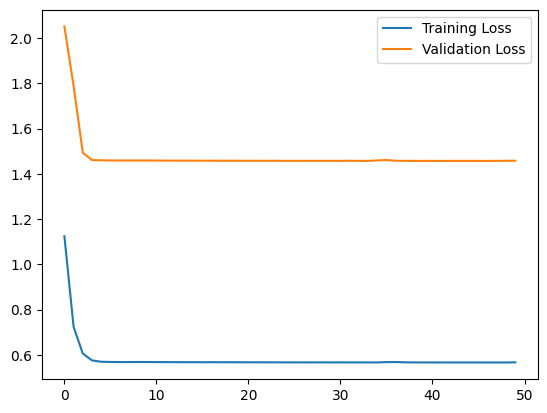

In [13]:


# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

Validation loss is higher than training loss - because model is looking at both normal and anomolous data for validation 

### Reasons to Include Anomalous Data in the Validation Set
- Performance Tracking on Anomalies: During training, you can use validation metrics (like reconstruction error) to see how well the model distinguishes normal from anomalous samples.
-  Since the model is trained on normal data, it should ideally show higher reconstruction errors on anomalous samples.


- Early Stopping: Having a mixed validation set can help you use early stopping based on a reconstruction error threshold that reflects performance on both types of data, potentially preventing overfitting to normal data.


- Threshold Selection: After training, you’ll need a reconstruction error threshold to classify new samples as normal or anomalous. - The validation set’s error distribution can help to choose this threshold.


In [14]:


# Use reconstruction error to detect anomalies
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=1)
mse


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


array([1.95150877e-01, 2.03744965e-01, 4.83461286e-02, 2.21985715e-01,
       3.41581288e-01, 1.33172453e+01, 3.01070630e-01, 9.46416792e-02,
       4.50691047e-02, 1.08325394e+00, 8.16862651e-01, 5.40747781e-02,
       2.85632211e-03, 1.05640234e-01, 4.70344771e-03, 1.30038758e-03,
       5.84126843e-01, 2.73890270e-04, 2.37044610e-01, 1.87392997e-01,
       1.40276736e+00, 1.79997235e-01, 1.72545020e-01, 1.13213709e+01,
       3.10303331e-01, 1.03467712e+00, 4.49236948e+00, 1.78112552e-03,
       8.54446787e-01, 8.03998902e-01, 5.32595114e+00, 3.03277006e-03,
       6.30732319e-01, 5.78159235e-01, 1.46211052e-03, 2.94329587e-01,
       7.44085740e-01, 1.16998025e+00, 3.67980663e-03, 1.43982156e-02,
       1.90152426e+00, 5.37321889e-01, 1.16122699e+01, 9.64167041e-03,
       5.90037593e-01, 3.42714356e-01, 1.03967232e+00, 3.01159739e+00,
       7.50547904e-01, 3.43594252e-02, 2.29085016e+00, 3.53440408e+00,
       5.97757604e-01, 4.20449726e-04, 9.66560967e-01, 1.46381004e-01,
      

In [15]:

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 95)  # Use the 95th percentile for threshold
print(f"Reconstruction error threshold: {threshold}")


Reconstruction error threshold: 9.570060475393925


In [16]:

# Predict anomalies
y_pred = mse > threshold
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")


Accuracy: 0.9952380952380953


In [17]:

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[198   0]
 [  1  11]]


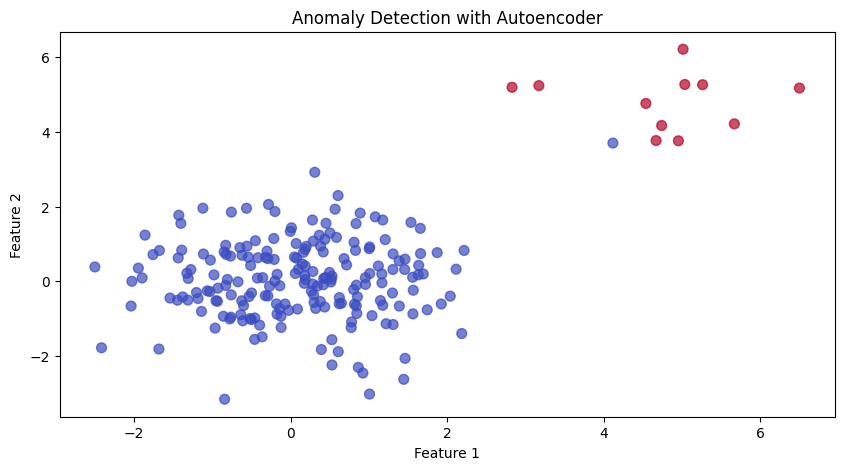

In [18]:

# Visualize results
plt.figure(figsize=(10, 5))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap="coolwarm", marker="o", s=50, alpha=0.7)
plt.title("Anomaly Detection with Autoencoder")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

### Time series data with anomalies

### Autoencoder with LSTM

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler



#### Normal data for Training data

- contrary to above approach where we used entire dataset for train test split and then later just used normal data as filtered
- here we use normal seq for training and anomalous seq for testing

In [69]:
# Normal data for training
np.random.seed(42)
time = np.linspace(0, 100, 1000)
normal_series = np.sin(time) + np.random.normal(scale=0.1, size=time.shape)
normal_series = MinMaxScaler().fit_transform(normal_series.reshape(-1, 1)).flatten()



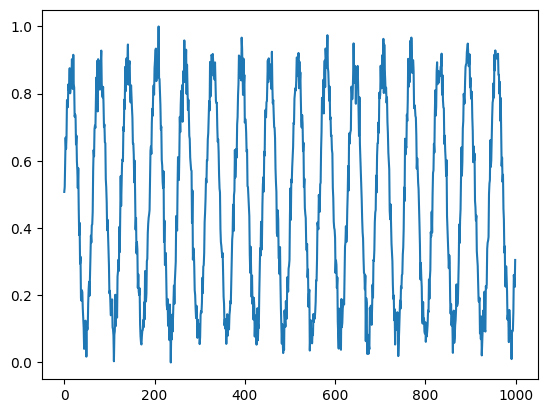

In [70]:
plt.plot(normal_series)

In [ ]:
# Prepare training sequences (from normal data)
def create_sequences(data, seq_length=48):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

sequence_length = 48
normal_sequences = create_sequences(normal_series, sequence_length)
normal_sequences = np.expand_dims(normal_sequences, axis=2)

#### Sequences for training
- When training an LSTM on the entire series -- especially for long sequences -- the memory and computational requirements can be very high. 
- Training on fixed-length sequences is more efficient and reduces the computational load
- This allows the model to learn effectively without overwhelming resources.



-- learning patterns :  the LSTM can learn local temporal patterns (e.g., the periodic behavior of normal data) within each sequence
- it increases the number of samples to learn

- Training on the entire series as a single sequence could lead the LSTM to memorize the sequence instead of generalizing to underlying patterns.
-  By using multiple shorter sequences -- allows LSTM to focus on learning the structure of normal patterns rather than memorizing.


#### Anomalous data for testing


In [71]:
# Anomalous data for testing
anomalous_series = normal_series.copy()
anomaly_indices = np.random.choice(np.arange(1000), size=48, replace=False)
anomalous_series[anomaly_indices] += np.random.normal(0, 2, size=48)  # Add anomalies

# Scale and reshape the entire series for testing
anomalous_series = MinMaxScaler().fit_transform(anomalous_series.reshape(-1, 1)).flatten()

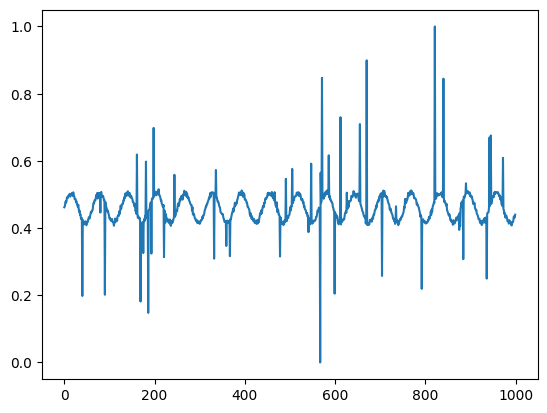

In [59]:
plt.plot(anomalous_series)

#### Complete series for testing in LSTM
- During testing, we are no longer trying to train the model , hence no need of sequences
- we want to evaluate how well it can distinguish between normal and anomalous parts.
- Anomalous series here is a combination of normal and anomlous parts -- calculating reconstruction errors for each point and detect anomalies
- In somecases, when the model sees the entire series -- it gets anomalies in the broder context 



-- however, 
- we can still use sequences for testing -- but it requires post processing and aggregation of errors to the original anomalous series
- but this has advantage of local errors and detect short anomalies 
- whereas in teh full series -- sometimes these short anomalies can be missed and robust sequence length estimates are required


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

model = Sequential([
    LSTM(64, input_shape=(sequence_length, 1)),
    RepeatVector(sequence_length),
    LSTM(64, return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')
model.fit(normal_sequences, normal_sequences, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


/opt/anaconda3/envs/mlflow/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1942 - val_loss: 0.0969
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0900 - val_loss: 0.0838
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0807 - val_loss: 0.0805
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0736 - val_loss: 0.0557
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0345 - val_loss: 0.0150
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0025 - val_l

In [61]:
# Prepare the entire anomalous series as overlapping sequences
test_sequences = create_sequences(anomalous_series, sequence_length)
test_sequences = np.expand_dims(test_sequences, axis=2)

# Get the reconstructions
reconstructions = model.predict(test_sequences)

# Calculate reconstruction error for each sequence
reconstruction_errors = np.mean(np.square(reconstructions - test_sequences), axis=(1, 2))

# Define a threshold based on training data
threshold = np.mean(reconstruction_errors) + 1.5 * np.std(reconstruction_errors)
anomalies = reconstruction_errors > threshold

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


#### Anomaly Threshold
- threshold based on the mean and standard deviation of reconstruction errors on normal data is set. 
- Sequences with errors above this threshold are flagged as anomalies.


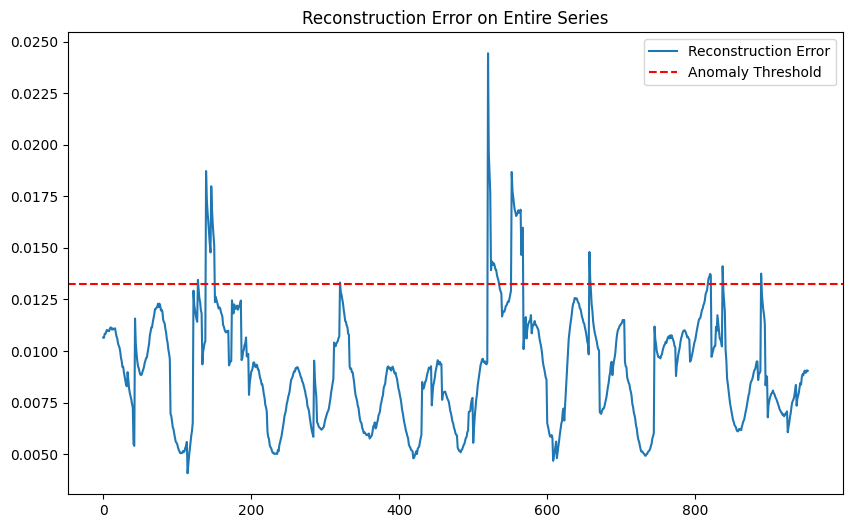

In [62]:
# Plot the reconstruction error along with the anomaly threshold
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.axhline(y=threshold, color='r', linestyle='--', label="Anomaly Threshold")
plt.legend()
plt.title("Reconstruction Error on Entire Series")
plt.show()


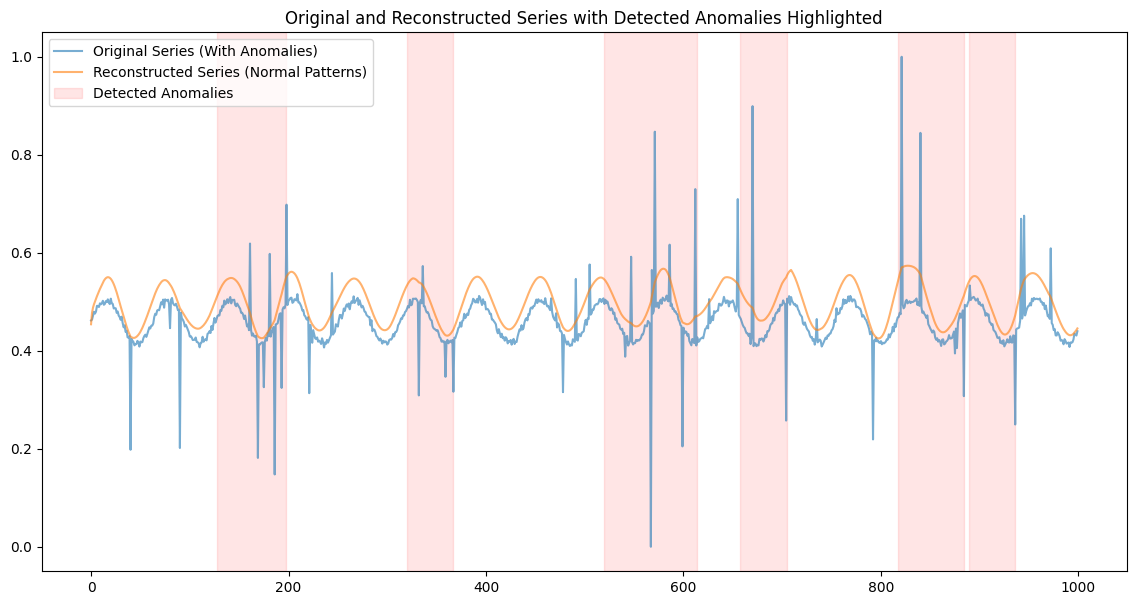

In [63]:
# Expand anomalies array to match the original series length
expanded_anomalies = np.zeros(len(anomalous_series), dtype=bool)
for i in range(len(anomalies)):
    if anomalies[i]:
        expanded_anomalies[i:i + sequence_length] = True

# Plot the original and reconstructed series, with detected anomalies highlighted
plt.figure(figsize=(14, 7))
plt.plot(anomalous_series, label="Original Series (With Anomalies)", alpha=0.6)
plt.plot(reconstructed_series, label="Reconstructed Series (Normal Patterns)", alpha=0.6)
plt.fill_between(range(len(anomalous_series)), 0, 1, where=expanded_anomalies, color='red', alpha=0.1, transform=plt.gca().get_xaxis_transform(), label="Detected Anomalies")
plt.legend()
plt.title("Original and Reconstructed Series with Detected Anomalies Highlighted")
plt.show()

#### Autoencoder with CNN

In [64]:
model = Sequential([
    # Encoder
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2, padding='same'),  # Keep padding='same' to maintain sequence length
    Conv1D(16, kernel_size=3, activation='relu', padding='same'),
    MaxPooling1D(pool_size=2, padding='same'),

    # Flatten to bottleneck
    Flatten(),
    Dense(16, activation='relu'),

    # Decoder
    Dense(16 * (sequence_length // 4), activation='relu'),  # Reshape back to match encoder output shape
    Reshape((sequence_length // 4, 16)),
    UpSampling1D(size=2),
    Conv1D(16, kernel_size=3, activation='relu', padding='same'),
    UpSampling1D(size=2),
    Conv1D(1, kernel_size=3, activation='sigmoid', padding='same')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/anaconda3/envs/mlflow/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 48, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 24, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │         3,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 192)            │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_4 (UpSampling1D)  │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 24, 16)         │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_5 (UpSampling1D)  │ (None, 48, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 48, 1)          │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,865 (34.63 KB)

 Trainable params: 8,865 (34.63 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
history = model.fit(normal_sequences, normal_sequences, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0776 - val_loss: 0.0415
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0230 - val_loss: 0.0048
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018 - val_lo

#### sequences for testing in CNN

In [74]:
anomalous_sequences = create_sequences(anomalous_series, sequence_length)
anomalous_sequences = np.expand_dims(anomalous_sequences, axis=2)

- We create overlapping -- fixed-length sequences (windows) and slide across the series.
- sliding-window approach -- the CNN autoencoder process each segment independently while preserving the model’s ability to capture local patterns within each window.

- The model outputs a reconstruction for each window
- calculate reconstruction errors on each window to detect anomalies.

In [77]:
# Reconstruct the sequences
reconstructions = model.predict(anomalous_sequences)

# Calculate reconstruction error
reconstruction_errors = np.mean(np.square(reconstructions - anomalous_sequences), axis=(1, 2))

# Set a dynamic anomaly threshold
threshold = np.mean(reconstruction_errors) + 1.5 * np.std(reconstruction_errors)
anomalies = reconstruction_errors > threshold

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


1.	LSTM (Sequential Processing): 
- LSTMs inherently process sequences in a way that allows for continuous time-series input (i.e., the entire series). 
- In the LSTM code, we fed the entire anomalous series as one continuous sequence during testing. 
- The LSTM’s ability to maintain temporal dependencies over a sequence makes it suitable for processing the entire series as a single entity.

	
2.	CNN (Fixed-size Window Processing): 
- CNNs, work by sliding a fixed-size filter over the data - which makes them well-suited for processing fixed-length windows or local patterns within a series.
- CNNs do not maintain an internal state (like LSTMs do) to remember previous parts of the sequence across the entire series. 
- Thus, in the CNN code, we split the anomalous series into smaller fixed-size sequences (windows) for processing.




-- We can use entire series for CNNs like LSTM
- this would lose the benifits of LOCAL ANOMALY DETECTION -- with sliding windows -- CNNs are good at this
- also, network needs to be deeper for global patterns across entrie series 
- if series is long - sometimes they overfit
- CNNs need FIXED SIZE INPUTS rather than entire sequences

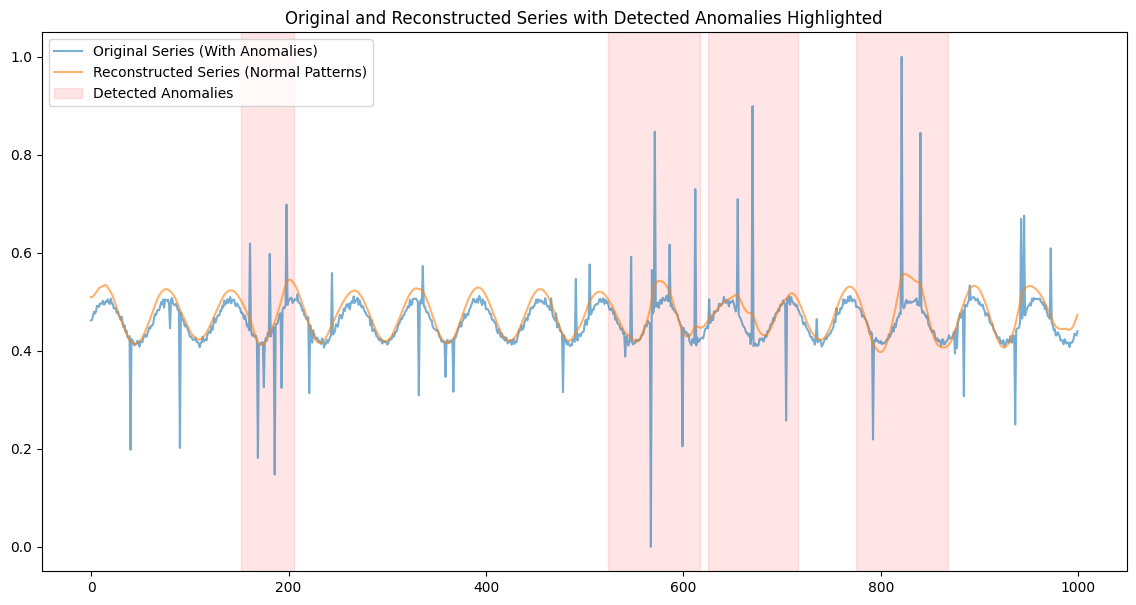

In [78]:
# Expand anomalies array to match the original series length
expanded_anomalies = np.zeros(len(anomalous_series), dtype=bool)
for i in range(len(anomalies)):
    if anomalies[i]:
        expanded_anomalies[i:i + sequence_length] = True

# Aggregate reconstructed sequences to form the full series
reconstructed_series = np.zeros_like(anomalous_series)
count_aggregation = np.zeros_like(anomalous_series)
for i, recon in enumerate(reconstructions):
    reconstructed_series[i:i + sequence_length] += recon.flatten()
    count_aggregation[i:i + sequence_length] += 1

# Average overlapping reconstructions
reconstructed_series /= count_aggregation

# Plot the original, reconstructed series and detected anomalies
plt.figure(figsize=(14, 7))
plt.plot(anomalous_series, label="Original Series (With Anomalies)", alpha=0.6)
plt.plot(reconstructed_series, label="Reconstructed Series (Normal Patterns)", alpha=0.6)
plt.fill_between(range(len(anomalous_series)), 0, 1, where=expanded_anomalies, color='red', alpha=0.1, transform=plt.gca().get_xaxis_transform(), label="Detected Anomalies")
plt.legend()
plt.title("Original and Reconstructed Series with Detected Anomalies Highlighted")
plt.show()